In [1]:
from vdyn.telemetry.aim import load_aim_csv
from vdyn.telemetry.laps import read_markers_and_segments_robust, extract_fastest_lap 
from vdyn.tracks.build import build_centerline_from_lap
from vdyn.tracks.track import CenterlineTrack, enforce_periodic_endpoints
from vdyn.limits.params_kart import KartParams
from vdyn.limits.lat_lim import v_from_kappa
from vdyn.limits.long_lim import a_x_max, a_x_min
from vdyn.utils.speed_profile import curvature_speed_profile, forward_backward_speed_profile

import numpy as np
import matplotlib.pyplot as plt

/home/alexp/projects/vehicle-dynamics-project/src/vdyn/telemetry/aim.py:79: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


Fastest lap: 52.245 s


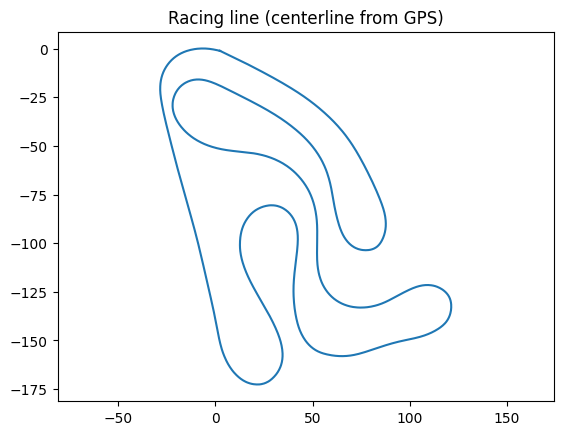

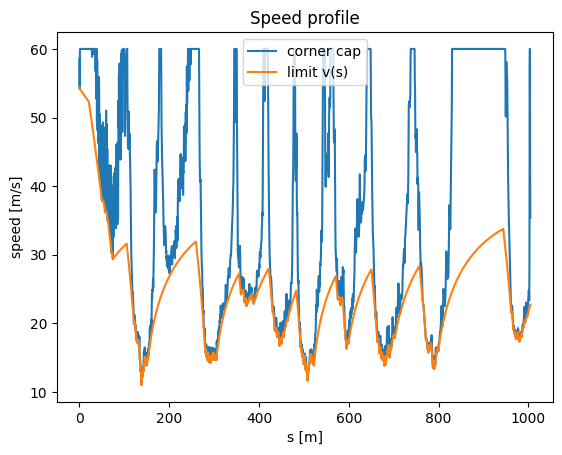

In [6]:
# --- 1) Load AiM / Race Studio CSV and cut the fastest lap ---
CSV_PATH = "../data/2.csv"
df = load_aim_csv(CSV_PATH)
markers_s, seg_times_s = read_markers_and_segments_robust(CSV_PATH)
lap_df, lap_info = extract_fastest_lap(df, markers_s, seg_times_s)
print(f"Fastest lap: {lap_info['lap_time']:.3f} s")

# --- 2) Build a smooth, uniform-s centerline from the lap GPS ---
# Requires the CSV to contain GPS Latitude / GPS Longitude columns
ctr = build_centerline_from_lap(lap_df, lat_col="GPS Latitude", lon_col="GPS Longitude", smooth_window=9, ds=0.5)
s = ctr["s"].to_numpy()
x = ctr["x"].to_numpy()
y = ctr["y"].to_numpy()
psi = ctr["psi"].to_numpy()
kappa = ctr["kappa"].to_numpy()

x, y, psi, kappa = enforce_periodic_endpoints(x, y, psi, kappa)

trk = CenterlineTrack(s, x, y, psi=psi, kappa=kappa)


# --- 4) Lateral cap (corner-limited speed) ---
p = KartParams()
v_cap_straight = 60.0  # m/s hard cap to keep things sane initially
# You can use either:
# (A) your helper that samples kappa internally:
S_grid, v_kappa = curvature_speed_profile(trk, a_lat_max=p.mu_lat*9.81, v_cap=v_cap_straight, n=len(s))
# or (B) direct kappa you already computed:
# v_kappa = v_from_kappa(KAP, p, v_cap=v_cap_straight); S_grid = S
ds = float(S_grid[1] - S_grid[0])

# --- 5) Longitudinal envelopes and forward–backward solver ---
axmax = lambda v: float(a_x_max(v, p))   # power fallback for now (no torque curve yet)
axmin = lambda v: float(a_x_min(v, p))   # braking
v_opt = forward_backward_speed_profile(S_grid, v_kappa, ds, axmax, axmin)

# --- 6) Quick plots ---
plt.figure(); plt.plot(X, Y); plt.axis('equal'); plt.title("Racing line (centerline from GPS)")
plt.figure(); plt.plot(S_grid, v_kappa, label="corner cap"); plt.plot(S_grid, v_opt, label="limit v(s)")
plt.xlabel("s [m]"); plt.ylabel("speed [m/s]"); plt.legend(); plt.title("Speed profile")
plt.show()
